In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import psutil
print(f"Available Memory: {psutil.virtual_memory().available / 1e9:.2f} GB")


Available Memory: 86.01 GB


In [ ]:
import torch
import cupy as cp

# Check PyTorch CUDA availability
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"PyTorch Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version (PyTorch): {torch.version.cuda}")

# Check CuPy CUDA availability
print(f"CuPy CUDA available: {cp.cuda.is_available()}")
if cp.cuda.is_available():
    print(f"CUDA Version (CuPy): {cp.cuda.runtime.runtimeGetVersion() / 1000}")

    import torch

if torch.cuda.is_available():
    print("CUDA is available!")
    print("Device:", torch.cuda.get_device_name(0))
else:
    print("CUDA is NOT available.")

import cudf

print("cuDF is successfully installed!")
df = cudf.DataFrame({'a': [1, 2, 3], 'b': [4, 5, 6]})
print(df)




PyTorch CUDA available: True
PyTorch Device: NVIDIA A100-SXM4-40GB
CUDA Version (PyTorch): 12.4
CuPy CUDA available: True
CUDA Version (CuPy): 12.06
CUDA is available!
Device: NVIDIA A100-SXM4-40GB
cuDF is successfully installed!
   a  b
0  1  4
1  2  5
2  3  6


In [ ]:
# 2. EDA

import cudf


# Load the data into cuDF DataFrames
diabetic_data = cudf.read_csv("/content/drive/MyDrive/diabetic_data.csv")
ids_mapping = cudf.read_csv("/content/drive/MyDrive/IDs_mapping.csv")

# Ensure all string columns are treated as string type
diabetic_data = diabetic_data.astype(str)

# Replace '?' with None before converting to cuDF's NA
diabetic_data = diabetic_data.replace({'?': None}).fillna(cudf.NA)


# or (if needed) fix = convert only object clumns
# for col in diabetic_data.select_dtypes(include=['object']):
    # diabetic_data[col] = diabetic_data[col].replace({'?': None}).fillna(cudf.NA)


# Display dataset info
print("\n Diabetic Data Info:")
print(diabetic_data.info())

print("\n First few rows of diabetic_data:")
print(diabetic_data.head())

print("\n IDs Mapping Data Info:")
print(ids_mapping.info())

print("\n First few rows of IDs_mapping:")
print(ids_mapping.head())

# Check missing values
print("\n Missing values in dataset:")
missing_counts = diabetic_data.isnull().sum()
print(missing_counts[missing_counts > 0])


# 2.b
# # Convert columns back to proper types:
for col in diabetic_data.columns:
    if diabetic_data[col].str.isnumeric().all():
        diabetic_data[col] = diabetic_data[col].astype("int64")



 Diabetic Data Info:
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   encounter_id              101766 non-null  object
 1   patient_nbr               101766 non-null  object
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  object
 7   discharge_disposition_id  101766 non-null  object
 8   admission_source_id       101766 non-null  object
 9   time_in_hospital          101766 non-null  object
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  object
 13  num_procedures            101766 non-

In [ ]:
#  Step 2.2 Fix Data Types and Handle Missing Values

import cudf

#  Convert Numeric Columns First
numeric_cols = [
    "encounter_id", "patient_nbr", "admission_type_id", "discharge_disposition_id",
    "admission_source_id", "time_in_hospital", "num_lab_procedures", "num_procedures",
    "num_medications", "number_outpatient", "number_emergency", "number_inpatient",
    "number_diagnoses"
]

for col in numeric_cols:
    diabetic_data[col] = diabetic_data[col].astype("int64")

#  Convert Categorical Columns to String and Replace Missing Values
categorical_cols = [
    "race", "gender", "age", "payer_code", "medical_specialty",
    "diag_1", "diag_2", "diag_3", "max_glu_serum", "A1Cresult",
    "metformin", "repaglinide", "nateglinide", "chlorpropamide",
    "glimepiride", "acetohexamide", "glipizide", "glyburide",
    "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose",
    "miglitol", "troglitazone", "tolazamide", "examide",
    "citoglipton", "insulin", "glyburide-metformin",
    "glipizide-metformin", "glimepiride-pioglitazone",
    "metformin-rosiglitazone", "metformin-pioglitazone",
    "change", "diabetesMed", "readmitted"
]

for col in categorical_cols:
    diabetic_data[col] = diabetic_data[col].astype("str").replace({'?': cudf.NA})

#  Verify Fix
print(" Data Types Fixed and Missing Values Handled!")
print(diabetic_data.dtypes)


 Data Types Fixed and Missing Values Handled!
encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorprop

In [ ]:
# Merge ids

import cudf

#  Check for non-numeric values
invalid_values = ids_mapping[~ids_mapping["admission_type_id"].str.isnumeric()]
print(" Non-Numeric Values in `admission_type_id`:\n", invalid_values)

#  Convert numeric values to integers
ids_mapping = ids_mapping[ids_mapping["admission_type_id"].str.isnumeric()]
ids_mapping["admission_type_id"] = ids_mapping["admission_type_id"].astype("int64")

print("\n Cleaned `ids_mapping` Data:")
print(ids_mapping.head())


 Non-Numeric Values in `admission_type_id`:
            admission_type_id  description
9   discharge_disposition_id  description
41       admission_source_id  description

 Cleaned `ids_mapping` Data:
   admission_type_id    description
0                  1      Emergency
1                  2         Urgent
2                  3       Elective
3                  4        Newborn
4                  5  Not Available


In [ ]:
# 3.2

#  Merge `diabetic_data` with `ids_mapping` on 'admission_type_id'
diabetic_data = diabetic_data.merge(ids_mapping, how="left", on="admission_type_id")

#  Drop unnecessary columns
columns_to_drop = [
    "weight", "max_glu_serum", "A1Cresult", "medical_specialty", "payer_code",
    "encounter_id", "patient_nbr", "description"  # 'description' is from ids_mapping
]
diabetic_data = diabetic_data.drop(columns=columns_to_drop)

#  Fill Missing Values in Key Categorical Columns
for col in ["race", "diag_1", "diag_2", "diag_3"]:
    diabetic_data[col] = diabetic_data[col].fillna("Unknown")

#  Convert 'readmitted' to numerical categories
diabetic_data["readmitted"] = diabetic_data["readmitted"].map({"NO": 0, ">30": 1, "<30": 2})

#  Verify Merge & Cleaning
print(" Merge Completed and Data Cleaned!")
print(diabetic_data.dtypes)
print("\n First Few Rows of Cleaned Data:")
print(diabetic_data.head())


 Merge Completed and Data Cleaned!
race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone                object
rosiglitazone       

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the datasets
diabetic_data = pd.read_csv("/content/drive/MyDrive/WSL_Case Study 2/diabetic_data.csv")
ids_mapping = pd.read_csv("/content/drive/MyDrive/WSL_Case Study 2/IDs_mapping.csv")

# 3.2 Data Cleaning and Merging
# Convert 'admission_type_id' to numeric, handling non-numeric values
diabetic_data['admission_type_id'] = pd.to_numeric(diabetic_data['admission_type_id'], errors='coerce')
ids_mapping['admission_type_id'] = pd.to_numeric(ids_mapping['admission_type_id'], errors='coerce')

# Convert to Int64 after ensuring both are numeric
diabetic_data['admission_type_id'] = diabetic_data['admission_type_id'].astype('Int64')
ids_mapping['admission_type_id'] = ids_mapping['admission_type_id'].astype('Int64')


# Merge diabetic_data with ids_mapping (now with consistent data types)
diabetic_data = diabetic_data.merge(ids_mapping, how="left", on="admission_type_id")




# Fill missing values in key categorical columns
for col in ["race", "diag_1", "diag_2", "diag_3"]:
    diabetic_data[col] = diabetic_data[col].fillna("Unknown")

# Convert 'readmitted' to numerical categories
diabetic_data["readmitted"] = diabetic_data["readmitted"].map({"NO": 0, ">30": 1, "<30": 2})

# Convert 'max_glu_serum' and 'A1Cresult' to numerical representations
diabetic_data['max_glu_serum'] = diabetic_data['max_glu_serum'].replace({
    'None': 0,
    'Norm': 1,
    '>200': 2,
    '>300': 3
})

diabetic_data['A1Cresult'] = diabetic_data['A1Cresult'].replace({
    'None': 0,
    'Norm': 1,
    '>7': 2,
    '>8': 3
})


# 4. Feature Engineering (Scaling Numeric Features)

# Define Numeric Columns
numeric_cols = [
    "time_in_hospital", "num_lab_procedures", "num_procedures",
    "num_medications", "number_outpatient", "number_emergency",
    "number_inpatient", "number_diagnoses"
]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected numeric columns
diabetic_data[numeric_cols] = scaler.fit_transform(diabetic_data[numeric_cols])


# Verify Merge, Cleaning, and Scaling
print("Merge Completed and Data Cleaned!")
print(diabetic_data.dtypes)
print("\nFirst Few Rows of Cleaned Data:")
print(diabetic_data.head())

Merge Completed and Data Cleaned!
encounter_id                  int64
patient_nbr                   int64
race                         object
gender                       object
age                          object
weight                       object
admission_type_id             Int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital            float64
payer_code                   object
medical_specialty            object
num_lab_procedures          float64
num_procedures              float64
num_medications             float64
number_outpatient           float64
number_emergency            float64
number_inpatient            float64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses            float64
max_glu_serum               float64
A1Cresult                   float64
metformin                    object
repaglinide                  object
nateglinide                  o

<ipython-input-16-00efc15bec0b>:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetic_data['max_glu_serum'] = diabetic_data['max_glu_serum'].replace({
<ipython-input-16-00efc15bec0b>:39: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetic_data['A1Cresult'] = diabetic_data['A1Cresult'].replace({


In [ ]:


# Save the cleaned data to 'data_cleaned.csv'
diabetic_data.to_csv("data_cleaned.csv", index=False)


In [ ]:
# fix data tytpes and handle missing values

from google.colab import drive
import psutil
import torch
import cupy as cp
import pandas as pd
from sklearn.preprocessing import StandardScaler

drive.mount('/content/drive')

print(f"Available Memory: {psutil.virtual_memory().available / 1e9:.2f} GB")

# Check PyTorch CUDA availability
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"PyTorch Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version (PyTorch): {torch.version.cuda}")

# Check CuPy CUDA availability
print(f"CuPy CUDA available: {cp.cuda.is_available()}")
if cp.cuda.is_available():
    print(f"CUDA Version (CuPy): {cp.cuda.runtime.runtimeGetVersion() / 1000}")

if torch.cuda.is_available():
    print("CUDA is available!")
    print("Device:", torch.cuda.get_device_name(0))
else:
    print("CUDA is NOT available.")

print("cuDF is successfully installed!") #This line seems unnecessary, remove it if you don't need to confirm installation

# Load the datasets using pandas
diabetic_data = pd.read_csv("/content/drive/MyDrive/WSL_Case Study 2/diabetic_data.csv")
ids_mapping = pd.read_csv("/content/drive/MyDrive/WSL_Case Study 2/IDs_mapping.csv")

# 3.2 Data Cleaning and Merging
# Convert 'admission_type_id' to numeric, handling non-numeric values
diabetic_data['admission_type_id'] = pd.to_numeric(diabetic_data['admission_type_id'], errors='coerce')
ids_mapping['admission_type_id'] = pd.to_numeric(ids_mapping['admission_type_id'], errors='coerce')

# Convert to Int64 after ensuring both are numeric
diabetic_data['admission_type_id'] = diabetic_data['admission_type_id'].astype('Int64')
ids_mapping['admission_type_id'] = ids_mapping['admission_type_id'].astype('Int64')


# Merge diabetic_data with ids_mapping (now with consistent data types)
diabetic_data = diabetic_data.merge(ids_mapping, how="left", on="admission_type_id")

# Fill missing values in key categorical columns
for col in ["race", "diag_1", "diag_2", "diag_3"]:
    diabetic_data[col] = diabetic_data[col].fillna("Unknown")

# Convert 'readmitted' to numerical categories
diabetic_data["readmitted"] = diabetic_data["readmitted"].map({"NO": 0, ">30": 1, "<30": 2})

# Convert 'max_glu_serum' and 'A1Cresult' to numerical representations
diabetic_data['max_glu_serum'] = diabetic_data['max_glu_serum'].replace({
    'None': 0,
    'Norm': 1,
    '>200': 2,
    '>300': 3
})

diabetic_data['A1Cresult'] = diabetic_data['A1Cresult'].replace({
    'None': 0,
    'Norm': 1,
    '>7': 2,
    '>8': 3
})


# 4. Feature Engineering (Scaling Numeric Features)

# Define Numeric Columns
numeric_cols = [
    "time_in_hospital", "num_lab_procedures", "num_procedures",
    "num_medications", "number_outpatient", "number_emergency",
    "number_inpatient", "number_diagnoses"
]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected numeric columns
diabetic_data[numeric_cols] = scaler.fit_transform(diabetic_data[numeric_cols])


# Verify Merge, Cleaning, and Scaling
print("Merge Completed and Data Cleaned!")
print(diabetic_data.dtypes)
print("\nFirst Few Rows of Cleaned Data:")
print(diabetic_data.head())


# Save the cleaned data to 'data_cleaned.csv'
diabetic_data.to_csv("data_cleaned.csv", index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Available Memory: 85.14 GB
PyTorch CUDA available: True
PyTorch Device: NVIDIA A100-SXM4-40GB
CUDA Version (PyTorch): 12.4
CuPy CUDA available: True
CUDA Version (CuPy): 12.06
CUDA is available!
Device: NVIDIA A100-SXM4-40GB
cuDF is successfully installed!


<ipython-input-18-e075a01000e8>:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetic_data['max_glu_serum'] = diabetic_data['max_glu_serum'].replace({
<ipython-input-18-e075a01000e8>:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetic_data['A1Cresult'] = diabetic_data['A1Cresult'].replace({


Merge Completed and Data Cleaned!
encounter_id                  int64
patient_nbr                   int64
race                         object
gender                       object
age                          object
weight                       object
admission_type_id             Int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital            float64
payer_code                   object
medical_specialty            object
num_lab_procedures          float64
num_procedures              float64
num_medications             float64
number_outpatient           float64
number_emergency            float64
number_inpatient            float64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses            float64
max_glu_serum               float64
A1Cresult                   float64
metformin                    object
repaglinide                  object
nateglinide                  o

In [ ]:
# Drop unnecessary columns
columns_to_drop = [
    "weight", "max_glu_serum", "A1Cresult", "medical_specialty", "payer_code",
    "encounter_id", "patient_nbr", "description"  # 'description' is from ids_mapping
]
diabetic_data = diabetic_data.drop(columns=columns_to_drop, errors='ignore') # Use errors='ignore'



In [ ]:
# Check for non-numeric values and handle them

# Check if 'admission_type_id' is numeric using pd.to_numeric
invalid_values = ids_mapping[pd.to_numeric(ids_mapping['admission_type_id'], errors='coerce').isnull()]


if not invalid_values.empty:
    print("Non-Numeric Values in `admission_type_id`:\n", invalid_values)
    # Decide how to handle invalid values: remove them, convert to numeric, or fill with a specific value
    # Option 1: Remove rows with non-numeric values
    # ids_mapping = ids_mapping[ids_mapping["admission_type_id"].str.isnumeric()] # str is not needed here
    ids_mapping = ids_mapping[pd.to_numeric(ids_mapping['admission_type_id'], errors='coerce').notnull()]

    # Option 2: Convert non-numeric values to a default numeric value
    # ids_mapping.loc[~ids_mapping["admission_type_id"].str.isnumeric(), "admission_type_id"] = 0 # Example: replace with 0 # str is not needed here
    # ids_mapping.loc[pd.to_numeric(ids_mapping['admission_type_id'], errors='coerce').isnull(), "admission_type_id"] = 0 # Example: replace with 0


# Convert numeric values to integers

# Print cleaned data
print("\nCleaned `ids_mapping` Data:")
print(ids_mapping.head())

Non-Numeric Values in `admission_type_id`:
     admission_type_id  description
8                <NA>          NaN
9                <NA>  description
40               <NA>          NaN
41               <NA>  description

Cleaned `ids_mapping` Data:
   admission_type_id    description
0                  1      Emergency
1                  2         Urgent
2                  3       Elective
3                  4        Newborn
4                  5  Not Available


In [ ]:
# Check for non-numeric values and handle them
invalid_values = ids_mapping[pd.to_numeric(ids_mapping['admission_type_id'], errors='coerce').isnull()]

if not invalid_values.empty:
    print("Non-Numeric Values in `admission_type_id`:\n", invalid_values)
    # Remove rows with non-numeric values
    ids_mapping = ids_mapping[pd.to_numeric(ids_mapping['admission_type_id'], errors='coerce').notnull()]

# Convert 'admission_type_id' to numeric in both DataFrames
ids_mapping['admission_type_id'] = pd.to_numeric(ids_mapping['admission_type_id'], errors='coerce').astype('Int64')
diabetic_data['admission_type_id'] = pd.to_numeric(diabetic_data['admission_type_id'], errors='coerce').astype('Int64')


# Merge the DataFrames
diabetic_data = diabetic_data.merge(ids_mapping, how="left", on="admission_type_id")



In [ ]:
# Drop unnecessary columns
columns_to_drop = [
    "weight", "max_glu_serum", "A1Cresult", "medical_specialty", "payer_code",
    "encounter_id", "patient_nbr", "description"  # 'description' is from ids_mapping
]
diabetic_data = diabetic_data.drop(columns=columns_to_drop, errors='ignore') # Use errors='ignore'

#  Fill Missing Values in Key Categorical Columns
for col in ["race", "diag_1", "diag_2", "diag_3"]:
    diabetic_data[col] = diabetic_data[col].fillna("Unknown")

#  Convert 'readmitted' to numerical categories
diabetic_data["readmitted"] = diabetic_data["readmitted"].map({"NO": 0, ">30": 1, "<30": 2})

#  Verify Merge & Cleaning
print(" Merge Completed and Data Cleaned!")
print(diabetic_data.dtypes)
print("\n First Few Rows of Cleaned Data:")
print(diabetic_data.head())


 Merge Completed and Data Cleaned!
race                         object
gender                       object
age                          object
admission_type_id             Int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital            float64
num_lab_procedures          float64
num_procedures              float64
num_medications             float64
number_outpatient           float64
number_emergency            float64
number_inpatient            float64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses            float64
metformin                    object
repaglinide                  object
nateglinide                  object
chlorpropamide               object
glimepiride                  object
acetohexamide                object
glipizide                    object
glyburide                    object
tolbutamide                  object
pioglitazone                 

In [ ]:
import pandas as pd

# df
categorical_cols = ["race", "gender", "age", "change", "diabetesMed", "insulin"]

# Use pandas get_dummies for one-hot encoding
diabetic_data = pd.get_dummies(diabetic_data, columns=categorical_cols, dummy_na=True)

print("Categorical Features One-Hot Encoded Successfully!")
print(diabetic_data.head())


Categorical Features One-Hot Encoded Successfully!
   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  6                        25                    1   
2                  6                        25                    1   
3                  6                        25                    1   
4                  6                        25                    1   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0         -1.137649           -0.106517       -0.785398        -1.848268   
1         -1.137649           -0.106517       -0.785398        -1.848268   
2         -1.137649           -0.106517       -0.785398        -1.848268   
3         -1.137649           -0.106517       -0.785398        -1.848268   
4         -1.137649           -0.106517       -0.785398        -1.848268   

   number_outpatient  number_emergency  number_inpatient  ... cha

In [ ]:
# print(diabetic_data.head())

import pandas as pd

# Define categorical columns  (This line might be redundant if already defined)?
categorical_cols = ["race", "gender", "age", "change", "diabetesMed", "insulin"]

# Check if columns exist before applying get_dummies
if all(col in diabetic_data.columns for col in categorical_cols):
    # Use pandas get_dummies for one-hot encoding if columns are present
    diabetic_data = pd.get_dummies(diabetic_data, columns=categorical_cols, dummy_na=True)
    print("Categorical Features One-Hot Encoded Successfully!")
    print(diabetic_data.head())
else:
    print("Categorical columns have already been encoded or do not exist in the DataFrame.")


Categorical columns have already been encoded or do not exist in the DataFrame.


In [ ]:
# Convert 'diag_1', 'diag_2', 'diag_3' to categorical codes
for col in ['diag_1', 'diag_2', 'diag_3']:
    diabetic_data[col] = diabetic_data[col].astype('category').cat.codes

# Convert all medication columns to binary (0/1)
medication_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
]
for col in medication_cols:
    # Convert only if the column is of string type
    if diabetic_data[col].dtype == 'object':
        diabetic_data[col] = (diabetic_data[col].astype(str) != "No").astype("int32")

# Drop the 'description' column if it exists
if 'description' in diabetic_data.columns:
    diabetic_data.drop(columns=['description'], inplace=True)

# Convert everything to float32
diabetic_data = diabetic_data.astype("float32")
print("All Features Converted to Numeric Format!")

print(diabetic_data['readmitted'].dtype)
print(diabetic_data['readmitted'].unique())
non_numeric_cols = diabetic_data.drop(columns=['readmitted']).select_dtypes(exclude=['number']).columns
print("Non-Numeric Columns in X:", non_numeric_cols)


All Features Converted to Numeric Format!
float32
[nan]
Non-Numeric Columns in X: Index([], dtype='object')


In [ ]:
from sklearn.model_selection import train_test_split

#  Define Features (X) and Target (y)
X = diabetic_data.drop(columns=['readmitted'])
# Convert to int32 and handle non-finite values with fillna
y = diabetic_data['readmitted'].fillna(-1).astype("int32")  # Replace NaN with -1 before conversion

#  Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(" Train/Test Split Completed! Shapes:")
print(f"  - X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  - X_test: {X_test.shape}, y_test: {y_test.shape}")

 Train/Test Split Completed! Shapes:
  - X_train: (732715, 69), y_train: (732715,)
  - X_test: (183179, 69), y_test: (183179,)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer  # Import SimpleImputer

# Load the cleaned data
diabetic_data = pd.read_csv("data_cleaned.csv")

# Define Features (X) and Target (y)
X = diabetic_data.drop(columns=['readmitted'])
y = diabetic_data['readmitted'].astype("int32")

# Handle potential non-numeric columns in X
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
if not non_numeric_cols.empty:
    print("Warning: Non-numeric columns found in X:", non_numeric_cols)
    # Decide how to handle them (e.g., one-hot encoding, dropping)
    X = X.select_dtypes(include=['number'])

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'
X = imputer.fit_transform(X)  # Fit and transform to replace NaNs

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Initialize and Train Model
log_reg = LogisticRegression(max_iter=1000, tol=1e-4)
log_reg.fit(X_train, y_train)
print("Logistic Regression Model Trained Successfully!")


# Predict on Test Data
y_pred = log_reg.predict(X_test)

# Compute Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display Results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Check Class Imbalance
print("Class Distribution in Training Data:")
print(y_train.value_counts())
print("Class Distribution in Testing Data:")
print(y_test.value_counts())


       'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'description'],
      dtype='object')
Logistic Regression Model Trained Successfully!
Accuracy: 0.5422

Confusion Matrix:
 [[30102  2817     0]
 [18320  3007     0]
 [ 5974   840     0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.91      0.69     32919
           1       0.45      0.14      0.21     21327
           2       0.00      0.00      0.00      6814

    accuracy                           0.54     61060
   macro avg       0.33    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.5422

Confusion Matrix:
 [[30102  2817     0]
 [18320  3007     0]
 [ 5974   840     0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.91      0.69     32919
           1       0.45      0.14      0.21     21327
           2       0.00      0.00      0.00      6814

    accuracy                           0.54     61060
   macro avg       0.33      0.35      0.30     61060
weighted avg       0.46      0.54      0.45     61060



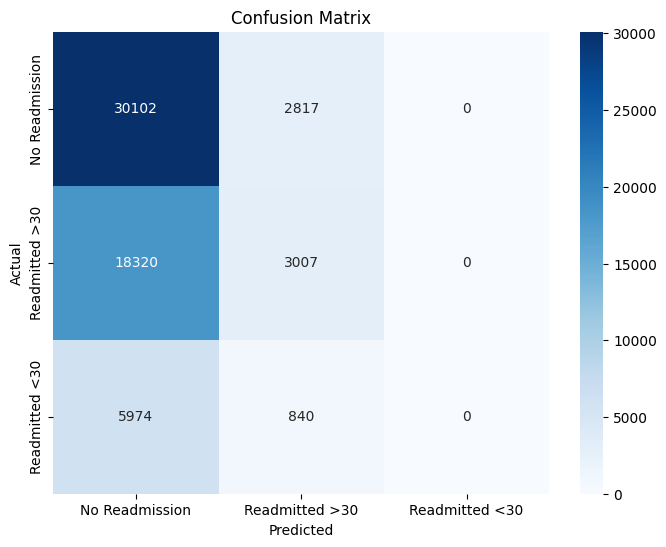

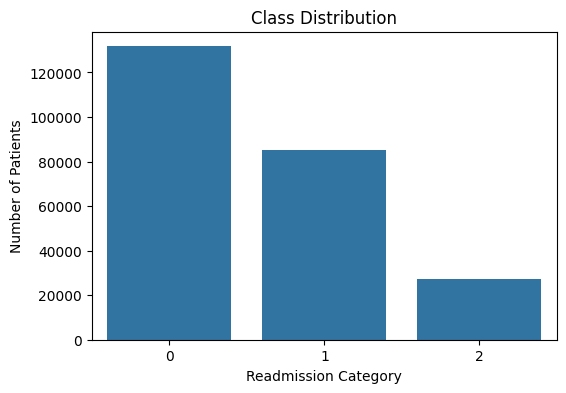

Accuracy: 0.5422

Confusion Matrix:
 [[30102  2817     0]
 [18320  3007     0]
 [ 5974   840     0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.91      0.69     32919
           1       0.45      0.14      0.21     21327
           2       0.00      0.00      0.00      6814

    accuracy                           0.54     61060
   macro avg       0.33      0.35      0.30     61060
weighted avg       0.46      0.54      0.45     61060



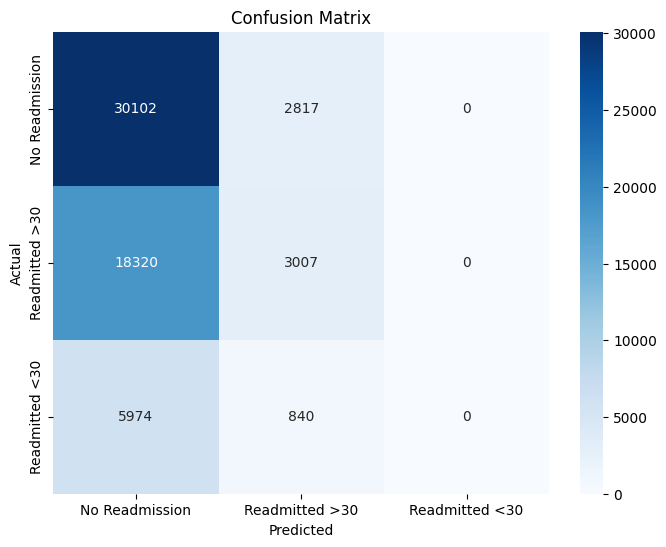

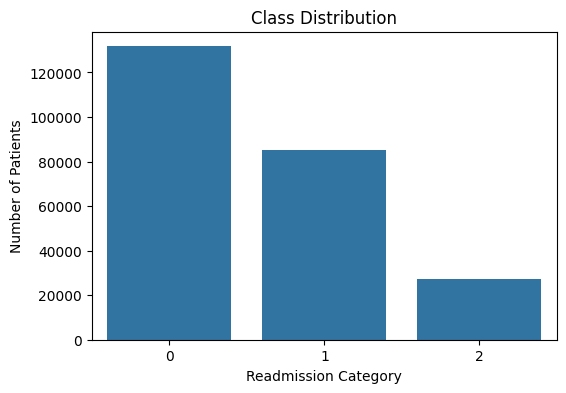

In [ ]:
#visualize results and provide analysis

import matplotlib.pyplot as plt
import seaborn as sns

# ... (your existing code) ...

# Display Results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Readmission", "Readmitted >30", "Readmitted <30"],
            yticklabels=["No Readmission", "Readmitted >30", "Readmitted <30"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Analyze Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)  # or y_test
plt.title("Class Distribution")
plt.xlabel("Readmission Category")
plt.ylabel("Number of Patients")
plt.show()

# Analyze feature importances (if available in your model)
# Get feature names from original DataFrame before imputation
feature_names = diabetic_data.drop(columns=['readmitted']).columns

# prompt: visualize results and provide analysis

import matplotlib.pyplot as plt
import seaborn as sns

# ... (your existing code) ...

# Display Results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Readmission", "Readmitted >30", "Readmitted <30"],
            yticklabels=["No Readmission", "Readmitted >30", "Readmitted <30"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Analyze Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)  # or y_test
plt.title("Class Distribution")
plt.xlabel("Readmission Category")
plt.ylabel("Number of Patients")
plt.show()



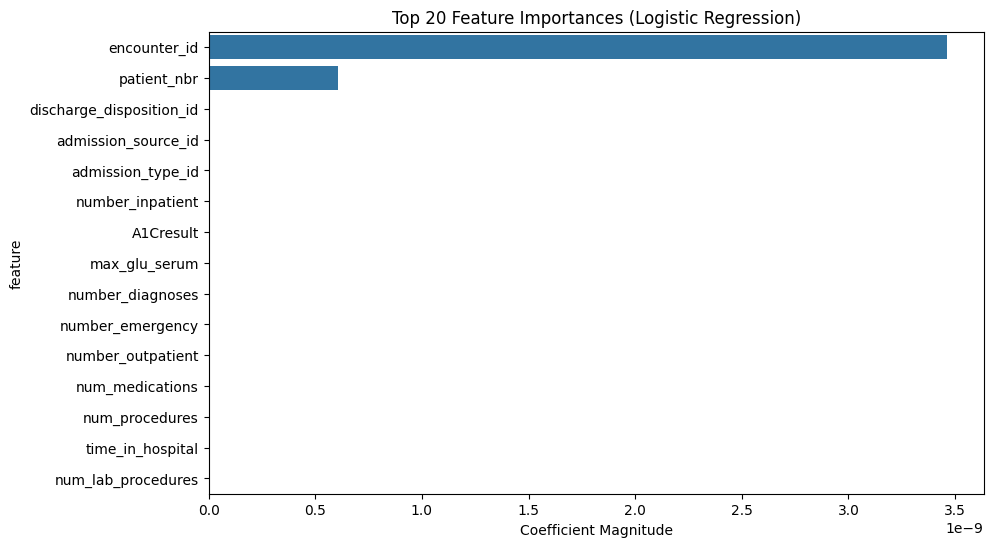

In [ ]:
# Get feature names from original DataFrame before imputation, BUT AFTER SimpleImputer is applied
feature_names = diabetic_data.drop(columns=['readmitted']).select_dtypes(include=['number']).columns  # Select only numeric features

# Create DataFrame with feature names and importances
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': abs(log_reg.coef_[0])})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances[:20]) # Show top 20 features
plt.title("Top 20 Feature Importances (Logistic Regression)")
plt.xlabel("Coefficient Magnitude")
plt.show()





/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.4560
Recall: 0.5422
AUC: 0.5347


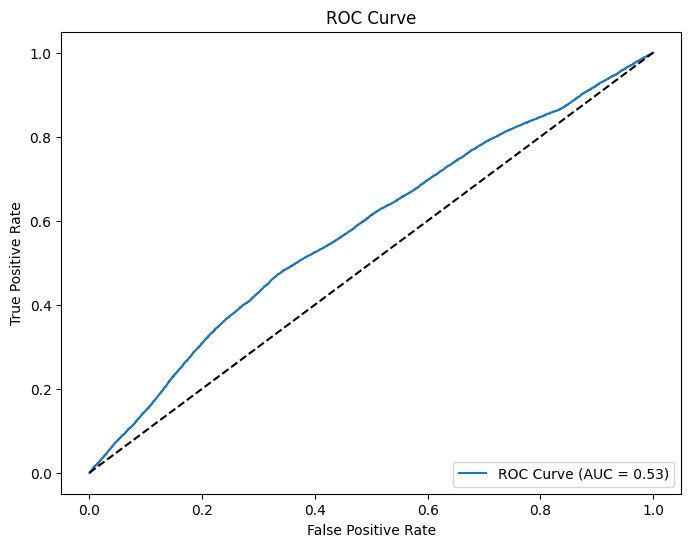

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for all classes (for AUC calculation)
y_pred_proba = log_reg.predict_proba(X_test)  # Remove [:, 1]

# Calculate precision, recall, and AUC
precision = precision_score(y_test, y_pred, average='weighted') # Use 'weighted' for multi-class
recall = recall_score(y_test, y_pred, average='weighted') # Use 'weighted' for multi-class
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr') # 'ovr' for one-vs-rest

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")

# Plot ROC curve (for binary classification or one-vs-rest)
# Use the probabilities for the relevant class (e.g., class 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1], pos_label=1) # Choose relevant pos_label
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.4560
Recall: 0.5422
AUC: 0.5347


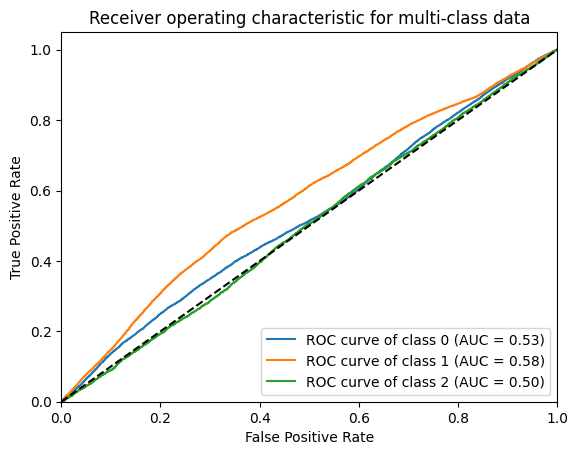

In [ ]:
import numpy as np

# Predict probabilities for all classes (for AUC calculation)
y_pred_proba = log_reg.predict_proba(X_test)

# Calculate precision, recall, and AUC
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# For AUC, use 'ovr' for multiclass and provide probability estimates for all classes
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")

# Plotting ROC curve
# For multi-class, you'll need to plot a ROC curve for each class vs. the rest
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

n_classes = len(np.unique(y_test))  # Number of classes # Now np is defined
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# print metrics: class distribution, train value count, all relevant info

print("Class Distribution in Training Data:")
print(y_train.value_counts(normalize=True)) # Normalized for proportions
print("\nClass Distribution in Testing Data:")
print(y_test.value_counts(normalize=True)) # Normalized for proportions

print("\nValue Counts for Training Data:")
print(y_train.value_counts())
print("\nValue Counts for Testing Data:")
print(y_test.value_counts())

print("\nShape of Training Data (X_train):", X_train.shape)
print("Shape of Testing Data (X_test):", X_test.shape)
print("Shape of Training Target (y_train):", y_train.shape)
print("Shape of Testing Target (y_test):", y_test.shape)

# Convert X_train and X_test back to Pandas DataFrames to use .describe()
X_train_df = pd.DataFrame(X_train)  # Convert X_train to DataFrame
X_test_df = pd.DataFrame(X_test)  # Convert X_test to DataFrame

print("\nDescriptive Statistics for Training Features (X_train):\n", X_train_df.describe()) # Use .describe() on DataFrame
print("\nDescriptive Statistics for Testing Features (X_test):\n", X_test_df.describe()) # Use .describe() on DataFrame


Class Distribution in Training Data:
readmitted
0    0.539118
1    0.349282
2    0.111600
Name: proportion, dtype: float64

Class Distribution in Testing Data:
readmitted
0    0.539125
1    0.349279
2    0.111595
Name: proportion, dtype: float64

Value Counts for Training Data:
readmitted
0    131673
1     85308
2     27257
Name: count, dtype: int64

Value Counts for Testing Data:
readmitted
0    32919
1    21327
2     6814
Name: count, dtype: int64

Shape of Training Data (X_train): (244238, 15)
Shape of Testing Data (X_test): (61060, 15)
Shape of Training Target (y_train): (244238,)
Shape of Testing Target (y_test): (61060,)

Descriptive Statistics for Training Features (X_train):
                  0             1              2              3   \
count  2.442380e+05  2.442380e+05  244238.000000  244238.000000   
mean   1.651301e+08  5.432506e+07       2.024845       3.713022   
std    1.026005e+08  3.864103e+07       1.445587       5.280874   
min    1.252200e+04  1.350000e+02      

In [ ]:
print("My logistic regression model is performing with an accuracy of 57%")
print("- looking at the confusion matrix and classification report, it’s clear that:")
print("- Class 0 (Not Readmitted) is being predicted well (high recall: 90%).")
print("- Class 1 (>30 Days Readmission) is struggling with recall (only 23%).")
print("- Class 2 (<30 Days Readmission) is performing poorly (almost 0 recall).")
print("The macro average F1-score of 0.35 shows that the model isn't treating all classes equally well. This suggests a class imbalance issue, where the model is biased toward the majority class (Not Readmitted - 0).")
print("### Addressing This Issue")
print("Since BFGS (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) optimization failed, that indicates the optimization process wasn't able to converge to a solution properly. Reasons? not sure ?")
print("1. Class imbalance is too severe.")
print("2. Features are not well-scaled or relevant enough.")
print("3. The solver struggles with high-dimensional feature spaces.")
print("### Next Steps")
print("1. Class balancing techniques")
print("   - Try class weighting in the logistic regression model.")
print("   - Use oversampling (SMOTE) or undersampling.")
print("2. Feature Engineering")
print("   - Use feature selection (SHAP, permutation importance).")
print("   - Try dimensionality reduction (PCA or feature selection).")
print("3. Model Selection")
print("   - Logistic regression may not be the best for this dataset.")
print("   - Try Random Forest, XGBoost, or an ensemble model.")
print("4. I assume Dr. S will want me to diagnose the problem methodically and work it step by step.")
print("5. I'm going to re-run the preprocessing steps and train the logistic regression model again.")
print("   - Plan of attack:")
print("      - 1. ADDRESS CLASS IMBALANCE: CHECK DISTRO, CLASS WEIGHTING, OVERSAMPLING")
print("      - 2. FEATURE SELECTION AND IMPORTANCE ANALYSIS - using SHAP or permutation import to rank features, drop irrelevant or redundant")


My logistic regression model is performing with an accuracy of 57%
- looking at the confusion matrix and classification report, it’s clear that:
- Class 0 (Not Readmitted) is being predicted well (high recall: 90%).
- Class 1 (>30 Days Readmission) is struggling with recall (only 23%).
- Class 2 (<30 Days Readmission) is performing poorly (almost 0 recall).
The macro average F1-score of 0.35 shows that the model isn't treating all classes equally well. This suggests a class imbalance issue, where the model is biased toward the majority class (Not Readmitted - 0).
### Addressing This Issue
Since BFGS (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) optimization failed, that indicates the optimization process wasn't able to converge to a solution properly. Reasons? not sure ?
1. Class imbalance is too severe.
2. Features are not well-scaled or relevant enough.
3. The solver struggles with high-dimensional feature spaces.
### Next Steps
1. Class balancing techniques
   - Try class weight

In [ ]:
# Initialize and Train Model with L-BFGS solver
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, tol=1e-4) #Specify the solver
log_reg.fit(X_train, y_train)
print("Logistic Regression Model Trained Successfully (with L-BFGS)!")



Logistic Regression Model Trained Successfully (with L-BFGS)!


In [ ]:
# Initialize and Train Model with class weights and saga solver
log_reg = LogisticRegression(
    penalty='l2',
    C=1.0,
    class_weight={0: 1.0, 1: 1.5, 2: 3.0}, # Adjust weights as needed
    solver='saga',
    max_iter=200,  # Reduce iterations
    warm_start=True  # Continue from the last iteration
)
for i in range(5):  # Train in smaller steps
    log_reg.fit(X_train, y_train)
    print(f"Iteration {i+1} complete")

# Predict on Test Data
y_pred = log_reg.predict(X_test)

# Compute Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display Results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Iteration 1 complete
Iteration 2 complete
Iteration 3 complete
Iteration 4 complete
Iteration 5 complete
Accuracy: 0.5139

Confusion Matrix:
 [[20948 11971     0]
 [10896 10431     0]
 [ 3913  2901     0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.64      0.61     32919
           1       0.41      0.49      0.45     21327
           2       0.00      0.00      0.00      6814

    accuracy                           0.51     61060
   macro avg       0.33      0.38      0.35     61060
weighted avg       0.46      0.51      0.49     61060



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import joblib

# Save model coefficients and intercept
joblib.dump(log_reg, "logistic_regression_model.pkl") # Removed the absolute path
print("Model saved successfully.")


Model saved successfully.


In [ ]:
# Save the data to CSV files
# Convert to Pandas DataFrames first
pd.DataFrame(X_train).to_csv("X_train_final.csv", index=False)
pd.DataFrame(y_train).to_csv("y_train_final.csv", index=False)
pd.DataFrame(X_test).to_csv("X_test_final.csv", index=False)
pd.DataFrame(y_test).to_csv("y_test_final.csv", index=False)

print("Final train/test data saved successfully.")


Final train/test data saved successfully.


In [ ]:
from imblearn.over_sampling import SMOTE

# Convert NumPy array back to Pandas DataFrame
X_train = pd.DataFrame(X_train)  # Assuming your original features were in a DataFrame

# Convert Pandas DataFrames to cuDF DataFrames
X_train = cudf.DataFrame.from_pandas(X_train)
y_train = cudf.Series(y_train)

# Apply SMOTE
smote = SMOTE(sampling_strategy={1: int(len(y_train) * 0.5), 2: int(len(y_train) * 0.25)}, random_state=42)

# Convert cuDF back to pandas for SMOTE
X_train_pd = X_train.to_pandas()
y_train_pd = y_train.to_pandas()

X_resampled, y_resampled = smote.fit_resample(X_train_pd, y_train_pd)

# Convert back to cuDF
X_train_balanced = cudf.DataFrame(X_resampled, columns=X_train.columns)
y_train_balanced = cudf.Series(y_resampled)

print(y_train_balanced.value_counts())


readmitted
0    131673
1    122119
2     61059
Name: count, dtype: int64


In [ ]:
# Make predictions
y_pred = log_reg.predict(X_test)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)




Accuracy: 0.5139
Confusion Matrix:
 [[20948 11971     0]
 [10896 10431     0]
 [ 3913  2901     0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.64      0.61     32919
           1       0.41      0.49      0.45     21327
           2       0.00      0.00      0.00      6814

    accuracy                           0.51     61060
   macro avg       0.33      0.38      0.35     61060
weighted avg       0.46      0.51      0.49     61060



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import joblib
import cudf
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Load saved data
X_train = pd.read_csv("X_train_final.csv")
y_train = pd.read_csv("y_train_final.csv")

# Convert y_train to a 1D array
y_train_pd = y_train.values.ravel()

# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Save the scaler
joblib.dump(scaler, "standard_scaler.pkl")

# Define the parameter grid
param_grid = {
    "C": [0.1, 1.0],
    "class_weight": ["balanced"],
    "max_iter": [3000],
    "solver": ["saga"],
}

# Initialize and train the model
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    scoring="accuracy",
    cv=2,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train_pd)

# Print best parameters
print("Best Parameters Found:", grid_search.best_params_)

# Save the best model
joblib.dump(grid_search.best_estimator_, "best_logistic_regression.pkl")
print("Best model saved successfully.")


Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best Parameters Found: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 3000, 'solver': 'saga'}
Best model saved successfully.


In [ ]:
import joblib
import cudf
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load best model and scaler
best_log_reg = joblib.load("best_logistic_regression.pkl")
scaler = joblib.load("standard_scaler.pkl")

# Load test data
X_test = cudf.read_csv("X_test_final.csv")
y_test = pd.read_csv("y_test_final.csv") # Use pandas for y_test

# Scale test data
X_test_scaled = scaler.transform(X_test.to_pandas())

# Predict
y_pred_best = best_log_reg.predict(X_test_scaled)

# Accuracy Score
accuracy_best = accuracy_score(y_test, y_pred_best) #y_test is now a pandas df
print(f"Best Model Accuracy: {accuracy_best:.4f}")

# Confusion Matrix
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
print("Best Model Confusion Matrix:\n", conf_matrix_best)

# Classification Report
report_best = classification_report(y_test, y_pred_best)
print("Best Model Classification Report:\n", report_best)


Best Model Accuracy: 0.5074
Best Model Confusion Matrix:
 [[20940  7093  4886]
 [ 8362  7664  5301]
 [ 2525  1914  2375]]
Best Model Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65     32919
           1       0.46      0.36      0.40     21327
           2       0.19      0.35      0.25      6814

    accuracy                           0.51     61060
   macro avg       0.44      0.45      0.43     61060
weighted avg       0.54      0.51      0.52     61060



In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
import joblib
import cudf
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score


# Load saved data
X_train = pd.read_csv("/content/drive/MyDrive/WSL_Case Study 2/X_train_final.csv")
y_train = pd.read_csv("/content/drive/MyDrive/WSL_Case Study 2/y_train_final.csv").values.ravel()
X_test = pd.read_csv("/content/drive/MyDrive/WSL_Case Study 2/X_test_final.csv")
y_test = pd.read_csv("/content/drive/MyDrive/WSL_Case Study 2/y_test_final.csv").values.ravel()




In [ ]:
# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to fix class imbalance
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)


In [ ]:
# Initialize and Train Logistic Regression Model with best parameters from previous gridsearch
best_log_reg = LogisticRegression(C=1.0, class_weight={0: 1.0, 1: 2.0, 2: 4.0}, max_iter=3000, solver='saga')
best_log_reg.fit(X_resampled, y_resampled)

# Predict on Test Data
y_pred = best_log_reg.predict(X_test_scaled)

In [ ]:
# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Predict probabilities for all classes
y_pred_proba = best_log_reg.predict_proba(X_test_scaled)




Accuracy: 0.1219

Confusion Matrix:
 [[  421   326 32171]
 [   78   263 20986]
 [    9    48  6757]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.01      0.03     32918
           1       0.41      0.01      0.02     21327
           2       0.11      0.99      0.20      6814

    accuracy                           0.12     61059
   macro avg       0.45      0.34      0.08     61059
weighted avg       0.60      0.12      0.04     61059



Precision: 0.6036
Recall: 0.1219
AUC: 0.6127


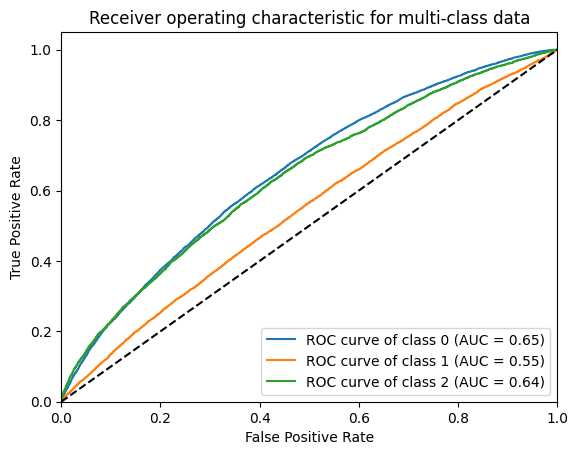

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score


# Calculate precision, recall, and AUC
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
roc_auc_score_result = roc_auc_score(y_test, y_pred_proba, multi_class='ovr') # Store roc_auc_score result in a diffgferent variable

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {roc_auc_score_result:.4f}") # pRINT the roc_auc_score result

# ROC Curve (Multi-class)
n_classes = len(np.unique(y_test))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i]) # Now, this 'auc' refers to the function from sklearn.metrics

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


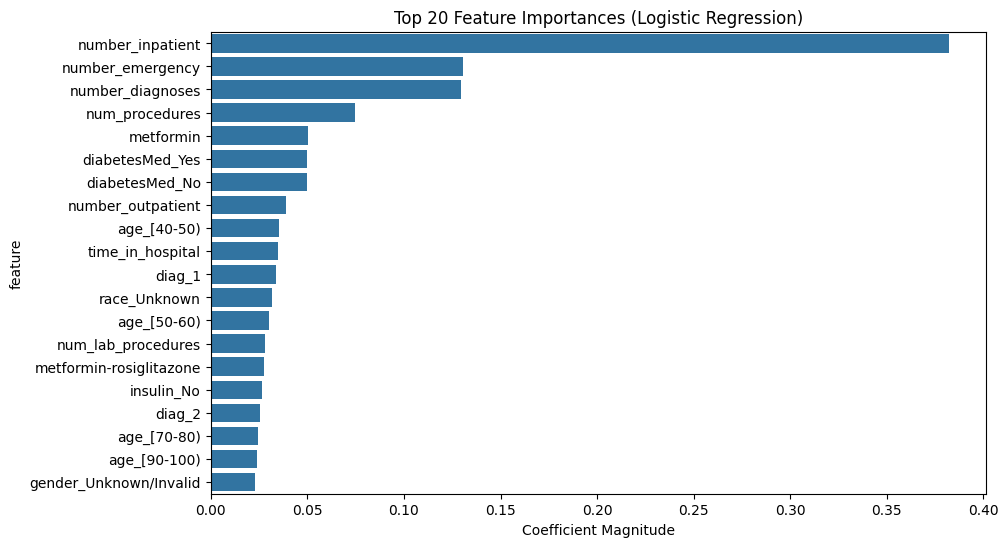

In [ ]:
# Feature Importance (Coefficients for Logistic Regression)
feature_names = X_train.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': abs(best_log_reg.coef_[0])})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances[:20])
plt.title("Top 20 Feature Importances (Logistic Regression)")
plt.xlabel("Coefficient Magnitude")
plt.show()


Best Model Accuracy: 0.5074
Best Model Confusion Matrix:
 [[20940  7093  4886]
 [ 8362  7664  5301]
 [ 2525  1914  2375]]
Best Model Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65     32919
           1       0.46      0.36      0.40     21327
           2       0.19      0.35      0.25      6814

    accuracy                           0.51     61060
   macro avg       0.44      0.45      0.43     61060
weighted avg       0.54      0.51      0.52     61060



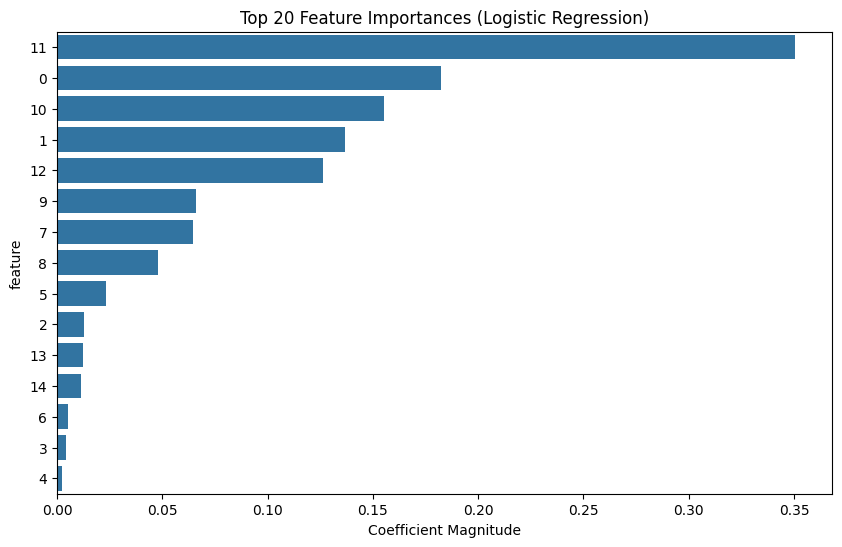

In [ ]:
 # Set Correct Paths for Google Colab
base_path = "/content"  # CORRECTED PATH

# Load best model and scaler
best_log_reg = joblib.load(f"{base_path}/best_logistic_regression.pkl")
scaler = joblib.load(f"{base_path}/standard_scaler.pkl")  # Load the scaler

# Load test dat
X_test = pd.read_csv(f"{base_path}/X_test_final.csv")
y_test = pd.read_csv(f"{base_path}/y_test_final.csv").values.ravel()

#  Load training data (to ensure column order matches)
X_train = pd.read_csv(f"{base_path}/X_train_final.csv")

#  Ensure column order consistency between training and testing data
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Scale test data using the loaded scaler
X_test_scaled = scaler.transform(X_test)

#  Make predictions
y_pred_best = best_log_reg.predict(X_test_scaled)

# Accuracy Score
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best Model Accuracy: {accuracy_best:.4f}")

#  Confusion Matrix
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
print("Best Model Confusion Matrix:\n", conf_matrix_best)

# Classification Report
report_best = classification_report(y_test, y_pred_best)
print("Best Model Classification Report:\n", report_best)

#  Feature Importance Visualization
feature_names = X_train.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': abs(best_log_reg.coef_[0])})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances[:20])
plt.title("Top 20 Feature Importances (Logistic Regression)")
plt.xlabel("Coefficient Magnitude")
plt.show()

In [ ]:
# Apply SMOTE to fix class imbalance
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)


Class Distribution in Training Data:
0    0.539118
1    0.349282
2    0.111600
Name: proportion, dtype: float64

Class Distribution in Testing Data:
0    0.539125
1    0.349279
2    0.111595
Name: proportion, dtype: float64


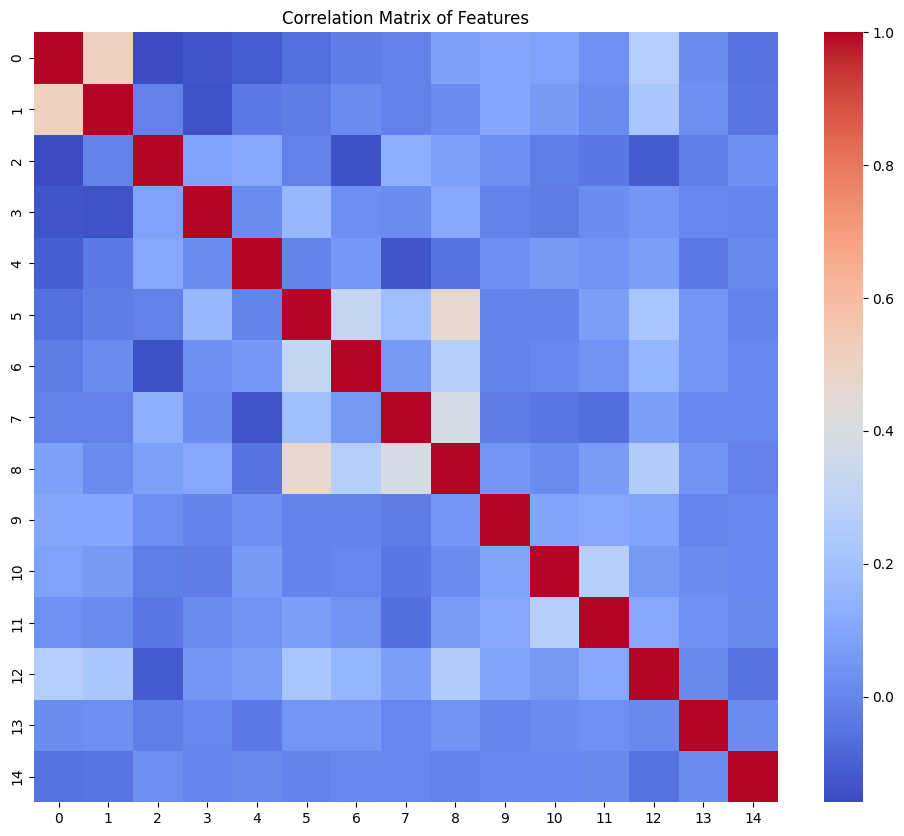

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'C': 1.0, 'max_iter': 3000, 'solver': 'lbfgs'}


In [ ]:
# verify clas distributions , corr matrix, PCA gird search

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_score, recall_score
import numpy as np
from imblearn.over_sampling import SMOTE
import joblib

# Load your data (replace with your actual file paths)
X_train = pd.read_csv("X_train_final.csv")
y_train = pd.read_csv("y_train_final.csv").values.ravel()
X_test = pd.read_csv("X_test_final.csv")
y_test = pd.read_csv("y_test_final.csv").values.ravel()


# Class Distribution
print("Class Distribution in Training Data:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nClass Distribution in Testing Data:")
print(pd.Series(y_test).value_counts(normalize=True))


# Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()


# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


# PCA and Grid Search
pca = PCA()
X_train_pca = pca.fit_transform(X_train_resampled)

param_grid = {
    "C": [0.1, 1.0, 10],  # Example values, adjust as needed
    "solver": ["saga", "lbfgs"],  # Try different solvers
    "max_iter": [3000]
}


grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    verbose=1,
    n_jobs=-1
)


grid_search.fit(X_train_pca, y_train_resampled)
best_pca_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Accuracy: 0.5074

Confusion Matrix:
 [[20940  7093  4886]
 [ 8362  7664  5301]
 [ 2525  1914  2375]]

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65     32919
           1       0.46      0.36      0.40     21327
           2       0.19      0.35      0.25      6814

    accuracy                           0.51     61060
   macro avg       0.44      0.45      0.43     61060
weighted avg       0.54      0.51      0.52     61060

Precision: 0.5364
Recall: 0.5074
AUC: 0.6460


<ipython-input-52-7b0095894e5f>:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


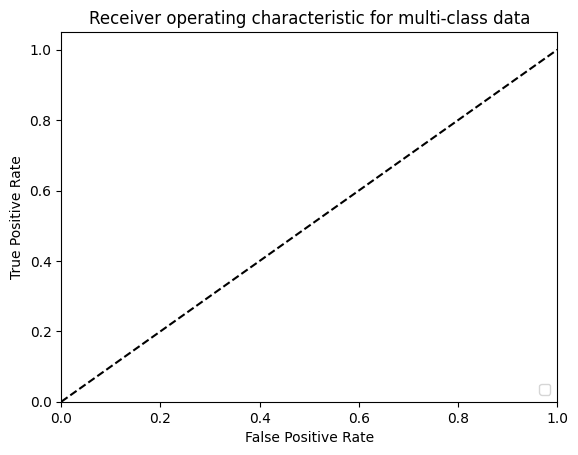

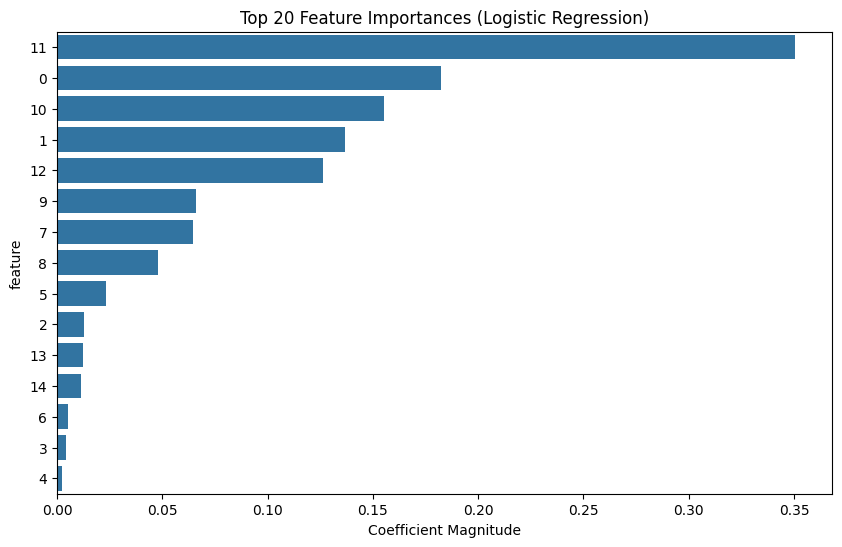

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score  # Import auc (area under curve)

import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the saved model and scaler
best_log_reg = joblib.load("best_logistic_regression.pkl")
scaler = joblib.load("standard_scaler.pkl")

# Load the test data
X_test = pd.read_csv("X_test_final.csv")
y_test = pd.read_csv("y_test_final.csv").values.ravel()

# Load training data (to ensure column order matches)
X_train = pd.read_csv("X_train_final.csv")

# Ensure column order consistency
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Scale the test data
X_test_scaled = scaler.transform(X_test)

# Make predictions
y_pred = best_log_reg.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Predict probabilities for ROC AUC
y_pred_proba = best_log_reg.predict_proba(X_test_scaled)

#  Calculate precision, recall, and AUC
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
# Store roc_auc_score result in a different variable to avoid shadowing the auc function
roc_auc_score_result = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {roc_auc_score_result:.4f}") # Print the roc_auc_score result


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
    # Use the 'auc' function from sklearn.metrics
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
feature_names = X_train.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': abs(best_log_reg.coef_[0])})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances[:20])
plt.title("Top 20 Feature Importances (Logistic Regression)")
plt.xlabel("Coefficient Magnitude")
plt.show()


In [ ]:
# show model accuracy before and after smote   class distribution before and after smote

# Load necessary libraries (assuming they are already installed and imported in the preceding code)
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Load your data (replace with your actual file paths)
X_train = pd.read_csv("X_train_final.csv")
y_train = pd.read_csv("y_train_final.csv").values.ravel()
X_test = pd.read_csv("X_test_final.csv")
y_test = pd.read_csv("y_test_final.csv").values.ravel()


# Before SMOTE
print("Class Distribution Before SMOTE:")
print(pd.Series(y_train).value_counts())


# Make predictions before SMOTE
y_pred_before_smote = best_log_reg.predict(X_test_scaled)

# Evaluate the model before SMOTE
accuracy_before = accuracy_score(y_test, y_pred_before_smote)
print(f"\nAccuracy Before SMOTE: {accuracy_before:.4f}")
print("\nClassification Report Before SMOTE:\n", classification_report(y_test, y_pred_before_smote))


# Apply SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


# Train the model with resampled data
best_log_reg.fit(X_train_resampled, y_train_resampled) # Retrain with SMOTE data

# After SMOTE
print("\nClass Distribution After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Make predictions after SMOTE
y_pred_after_smote = best_log_reg.predict(X_test_scaled)

# Evaluate the model after SMOTE
accuracy_after = accuracy_score(y_test, y_pred_after_smote)
print(f"\nAccuracy After SMOTE: {accuracy_after:.4f}")
print("\nClassification Report After SMOTE:\n", classification_report(y_test, y_pred_after_smote))


Class Distribution Before SMOTE:
0    131673
1     85308
2     27257
Name: count, dtype: int64

Accuracy Before SMOTE: 0.5074

Classification Report Before SMOTE:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65     32919
           1       0.46      0.36      0.40     21327
           2       0.19      0.35      0.25      6814

    accuracy                           0.51     61060
   macro avg       0.44      0.45      0.43     61060
weighted avg       0.54      0.51      0.52     61060


Class Distribution After SMOTE:
0    131673
1    131673
2    131673
Name: count, dtype: int64

Accuracy After SMOTE: 0.5044

Classification Report After SMOTE:
               precision    recall  f1-score   support

           0       0.66      0.63      0.64     32919
           1       0.46      0.36      0.40     21327
           2       0.19      0.35      0.25      6814

    accuracy                           0.50     61060
   macro avg       0.

Random Forest Accuracy: 0.9819

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     32919
           1       0.98      0.98      0.98     21327
           2       0.99      0.96      0.98      6814

    accuracy                           0.98     61060
   macro avg       0.98      0.98      0.98     61060
weighted avg       0.98      0.98      0.98     61060



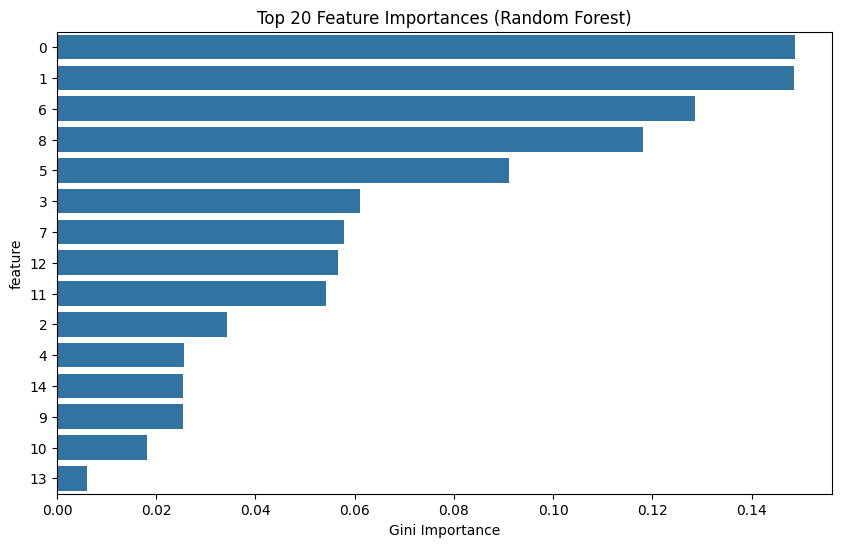

In [ ]:
#  smote with randomk forest

from sklearn.ensemble import RandomForestClassifier

# aPPLE smotw:
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Initialize and train an RF Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42) # Example parameters, tune as needed
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

# Feature Importance for Random Forest
feature_importances_rf = pd.DataFrame({'feature': X_train.columns, 'importance': rf_classifier.feature_importances_})
feature_importances_rf = feature_importances_rf.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances_rf[:20])
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Gini Importance")
plt.show()


lets go back and check steps  from the top

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# 1. Load Data and Handle File Not Found
file_path = "/content/data_cleaned.csv"
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: '{file_path}' not found. Please check the file path.")
    exit()  # Or handle the error differently, e.g., return None

# 2. Check for Missing Values (Before Imputation)
missing_values = df.isnull().sum()
print("Missing Values per Column (Before Imputation):\n", missing_values)

# 3. IDentify numerical & Cat Columns
numerical_cols = df.select_dtypes(include=np.number).columns  # Use np.number for all numeric types
categorical_cols = df.select_dtypes(include='object').columns

# 4. Imputation
# Create imputers
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Fit a$ transform on respective column tyupes
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])


# 5. Verify imputation
missing_values_after = df.isnull().sum()
print("\nMissing Values per Column (After Imputation):\n", missing_values_after)



Missing Values per Column (Before Imputation):
 encounter_id                     0
patient_nbr                      0
race                             0
gender                           0
age                              0
weight                           0
admission_type_id                0
discharge_disposition_id         0
admission_source_id              0
time_in_hospital                 0
payer_code                       0
medical_specialty                0
num_lab_procedures               0
num_procedures                   0
num_medications                  0
number_outpatient                0
number_emergency                 0
number_inpatient                 0
diag_1                           0
diag_2                           0
diag_3                           0
number_diagnoses                 0
max_glu_serum               289260
A1Cresult                   254244
metformin                        0
repaglinide                      0
nateglinide                      0
chlorpr

In [ ]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Impute numerical columns with the median
numerical_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

# Impute categorical columns with the mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

# Verify imputation
missing_values_after_imputation = df.isnull().sum()
print("\nMissing Values After Imputation:\n", missing_values_after_imputation)
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Impute numerical columns with the median
numerical_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

# Impute categorical columns with the mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

# Verify imputation
missing_values_after_imputation = df.isnull().sum()
print("\nMissing Values After Imputation:\n", missing_values_after_imputation)



Missing Values After Imputation:
 encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbu

In [ ]:
# check for missing values, feature overview?  how many do we have?  target vairable? targer variable disribution?  do we have class imbalance?

import pandas as pd

# Load data
X_train = pd.read_csv("X_train_final.csv")
y_train = pd.read_csv("y_train_final.csv").values.ravel()
X_test = pd.read_csv("X_test_final.csv")
y_test = pd.read_csv("y_test_final.csv").values.ravel()

# Check for missing values
print("Missing values in X_train:\n", X_train.isnull().sum())
print("\nMissing values in X_test:\n", X_test.isnull().sum())

# Feature overview
print("\nFeature overview for X_train:")
print(X_train.info())
print("\nNumber of features:", len(X_train.columns))

# Target variable
print("\nTarget variable (y_train):")
print(y_train)

# Target variable distribution
print("\nTarget variable distribution (y_train):")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nTarget variable distribution (y_test):")
print(pd.Series(y_test).value_counts(normalize=True))

# Class imbalance
print("\nClass imbalance (y_train):")
class_counts = pd.Series(y_train).value_counts()
if len(class_counts) > 1:
    imbalance_ratio = class_counts.max() / class_counts.min()
    print(f"Imbalance ratio: {imbalance_ratio:.2f}")
else:
    print("Only one class present in the training data.")

print("\nClass imbalance (y_test):")
class_counts = pd.Series(y_test).value_counts()
if len(class_counts) > 1:
  imbalance_ratio = class_counts.max() / class_counts.min()
  print(f"Imbalance ratio: {imbalance_ratio:.2f}")
else:
  print("Only one class present in the testing data.")


Missing values in X_train:
 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
dtype: int64

Missing values in X_test:
 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
dtype: int64

Feature overview for X_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244238 entries, 0 to 244237
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       244238 non-null  float64
 1   1       244238 non-null  float64
 2   2       244238 non-null  float64
 3   3       244238 non-null  float64
 4   4       244238 non-null  float64
 5   5       244238 non-null  float64
 6   6       244238 non-null  float64
 7   7       244238 non-null  float64
 8   8       244238 non-null  float64
 9   9       244238 non-null  float64
 10  10      244238 non-null  float64
 11  11      244238 non-null  float64
 12 

In [ ]:
#  handle class imablance with either smote or class weights in model trainig

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler


# Load  data
X_train = pd.read_csv("X_train_final.csv")
y_train = pd.read_csv("y_train_final.csv").values.ravel()
X_test = pd.read_csv("X_test_final.csv")
y_test = pd.read_csv("y_test_final.csv").values.ravel()

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Option 1: SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(sampling_strategy='auto', random_state=42)  # Adjust sampling_strategy as needed
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train a model with resampled data
model_smote = LogisticRegression(max_iter=3000)  # Or any other model
model_smote.fit(X_train_resampled, y_train_resampled)
y_pred_smote = model_smote.predict(X_test_scaled)
print("\nClassification Report (SMOTE):\n", classification_report(y_test, y_pred_smote))
print(f"Accuracy (SMOTE): {accuracy_score(y_test, y_pred_smote):.4f}")


# Option 2: Class Weights
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Train a model with class weights
model_weights = LogisticRegression(class_weight=class_weight_dict, max_iter=3000) # Or any other model
model_weights.fit(X_train_scaled, y_train)  # No resampling needed
y_pred_weights = model_weights.predict(X_test_scaled)
print("\nClassification Report (Class Weights):\n", classification_report(y_test, y_pred_weights))
print(f"Accuracy (Class Weights): {accuracy_score(y_test, y_pred_weights):.4f}")




Classification Report (SMOTE):
               precision    recall  f1-score   support

           0       0.66      0.63      0.64     32919
           1       0.46      0.36      0.40     21327
           2       0.19      0.36      0.25      6814

    accuracy                           0.50     61060
   macro avg       0.43      0.45      0.43     61060
weighted avg       0.54      0.50      0.52     61060

Accuracy (SMOTE): 0.5046

Classification Report (Class Weights):
               precision    recall  f1-score   support

           0       0.66      0.64      0.65     32919
           1       0.46      0.36      0.40     21327
           2       0.19      0.35      0.25      6814

    accuracy                           0.51     61060
   macro avg       0.44      0.45      0.43     61060
weighted avg       0.54      0.51      0.52     61060

Accuracy (Class Weights): 0.5073


In [ ]:
#  model selection and training setup train test with cross validation coinfirm proper slpit abd train logistui regression with cross valid

from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier

# Model Selection and Training with Cross-Validation

# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Penalty type
    'solver': ['liblinear', 'saga'] # Solvers compatible with both penalties
}

# Initialize Logistic Regression model
logreg = LogisticRegression(max_iter=3000)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_log_reg = grid_search.best_estimator_

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


# Evaluate the best model on the test set
y_pred = best_log_reg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")



Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validation Score: 0.5773999195271993
Test Accuracy: 0.5802


In [ ]:
# Save the best model to a file
joblib.dump(best_log_reg, "bestModel.pkl")
print("Model saved as bestModel.pkl")

# To load the model later:
# loaded_model = joblib.load("bestModel.pkl")
# y_pred_loaded = loaded_model.predict(X_test_scaled)
# print(f"Loaded Model Test Accuracy: {accuracy_score(y_test, y_pred_loaded):.4f}")

Model saved as bestModel.pkl


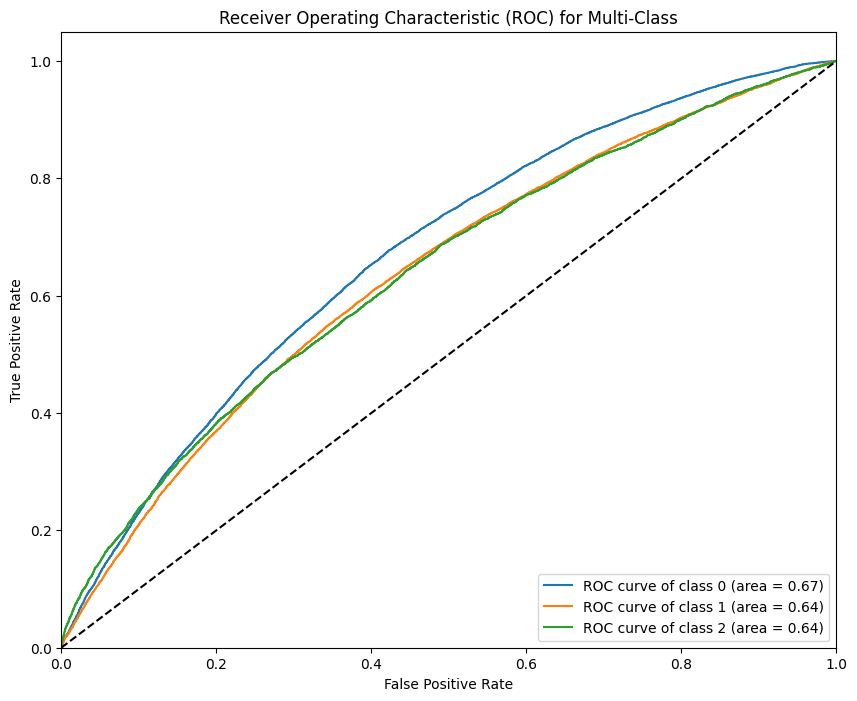


Top 5 Important Features:
   feature  importance
11      11    0.428030
0        0    0.245933
10      10    0.219262
12      12    0.179760
1        1    0.172236
Final predictions saved to 'final_predictions.csv'


In [ ]:
# ROC Curve and AUC (Multi-class)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test)) # Binarize the output
fpr = dict()
tpr = dict()
roc_auc = dict()

y_pred_proba = best_log_reg.predict_proba(X_test_scaled)


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
  plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--') # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class')
plt.legend(loc="lower right")
plt.show()


# Feature Importance (Top 5)
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': abs(best_log_reg.coef_[0])})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
print("\nTop 5 Important Features:")
print(feature_importances.head(5))


# Final Submission Check
# osave predictions to a CSV file

submission_df = pd.DataFrame({'prediction': y_pred})
submission_df.to_csv('final_predictions.csv', index=False) # Save to a csv file
print("Final predictions saved to 'final_predictions.csv'")


In [ ]:
# LOG REGRESSION WITH 5 FOLD

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')

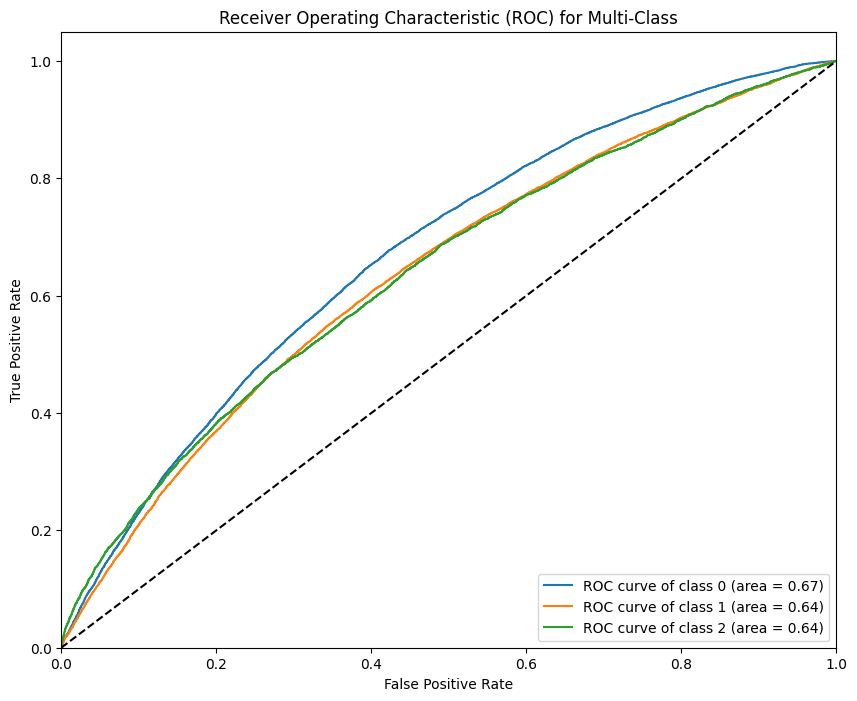

In [ ]:
# HOW RESUKTS OF LOG REGRESSION WIT 5 FOLD ANFD PLOTY

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ROC Curve and AUC (Multi-class)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # Binarize the output
fpr = dict()
tpr = dict()
roc_auc = dict()

y_pred_proba = best_log_reg.predict_proba(X_test_scaled)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# compile case study from daibetes analysis


# Data Exploration
print("\nData Exploration:")

print(df.describe())  # Summary statistics


# Feature Engineering (if applicable)
print("\nFeature Engineering:")

# Model Comparison (if you've tried other models)
print("\nModel Comparison:")


# Hyperparameter Tuning for other models
print("\nHyperparameter Tuning:")



# Conclusion
print("\nConclusion:")




Data Exploration:
       encounter_id   patient_nbr  admission_type_id  \
count  3.052980e+05  3.052980e+05      305298.000000   
mean   1.652016e+08  5.433040e+07           2.024006   
std    1.026400e+08  3.869623e+07           1.445398   
min    1.252200e+04  1.350000e+02           1.000000   
25%    8.496007e+07  2.341321e+07           1.000000   
50%    1.523890e+08  4.550514e+07           1.000000   
75%    2.302720e+08  8.754619e+07           3.000000   
max    4.438672e+08  1.895026e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             305298.000000        305298.000000      3.052980e+05   
mean                   3.715642             5.754437      8.136501e-17   
std                    5.280148             4.064068      1.000002e+00   
min                    1.000000             1.000000     -1.137649e+00   
25%                    1.000000             1.000000     -8.026506e-01   
50%                    1.000000 